In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
from tqdm.notebook import tqdm

In [0]:
# Ensure reproducibility
random.seed(11)
np.random.seed(11)

# Water Maze Template

In [0]:
####################################################################################################
# watermaze module
####################################################################################################
class watermaze(object):
    
    """
    This class defines a set of functions for simulating a rat moving in a water-maze.
    
    For the purposes of this assignment, you should be using the move function to 
    determine the next state of the environment at each time-step of the simulation.
    
    See the demo of its usage after the module code.
    """
    
    ####################################################################
    # the initialization function, measurements are in cm
    def __init__(self, pool_radius=60, platform_radius=10, platform_location=np.array([25, 25]), 
                 stepsize=5.0, momentum=0.2, T=60):
        
        """
        The init function for the watermaze module.
        
        - The pool_radius argument specifies the radius of the pool.
        
        - The platform_radius argument specifies the radius of the platform.
        
        - The platform_location argument specifies the location of the platform centre.
        
        - The stepsize argument specifies how far the rat moves in one step.
        
        - The momentum argument specifies the ratio of old movement to new movement direction (i.e. 
        momentum = 0 means all new movement, momentum = 1 means all old movement, otherwise a mix.
        
        - The T argument is the maximum time for a trial in the pool.

        
        """
        
        # store the given info
        self.radius            = pool_radius
        self.platform_radius   = platform_radius
        self.platform_location = platform_location
        self.stepsize          = stepsize
        self.momentum          = momentum
        self.T                 = T
        
        # a dictionary for calculating directions
        self.direction = {
            0:  np.pi/2,   #north
            1:  np.pi/4,   #north-east
            2:  0,         #east
            3:  7*np.pi/4, #south-east
            4:  3*np.pi/2, #south
            5:  5*np.pi/4, #south-west
            6:  np.pi,     #west
            7:  3*np.pi/4, #north-west
        }
        
        # initialize the dynamic variables
        self.position = np.zeros((2,T))
        self.t        = 0
        self.prevdir  = np.zeros((2,))
        
    ####################################################################
    # for updating the rat's position in the pool
    def move(self, A, angle=None):

        """
        Updates the simulated rat's position in the water-maze environment by moving it in the 
        specified direction. 
        
        - The argument A is the last selected action, and must be an integer from 0-7, with 0 indicating N, 
        1 indicating NE, etc. 

        """
        
        # check the A argument
        if np.isin(A, np.arange(8)):
            angle = self.direction[A]
        elif A != 8:
            raise ValueError('Error: The argument A must be an integer from 0-8, indicating which action was selected.')
        
        # determine the vector of direction of movement
        newdirection = np.array([np.cos(angle), np.sin(angle)])
        
        # add in momentum to reflect actual swimming dynamics (and normalize, then multiply by stepsize)
        direction = (1.0 - self.momentum)*newdirection + self.momentum*self.prevdir
        direction = direction/np.sqrt((direction**2).sum())
        direction = direction*self.stepsize
        
        # update the position, prevent the rat from actually leaving the water-maze by having it "bounce" off the wall 
        [newposition, direction] = self.poolreflect(self.position[:,self.t] + direction)

        # if we're now at the very edge of the pool, move us in a little-bit
        if (np.linalg.norm(newposition) == self.radius):
            newposition = np.multiply(np.divide(newposition,np.linalg.norm(newposition)),(self.radius - 1))

        # update the position, time (and previous direction)
        self.position[:,self.t+1] = newposition
        self.t                    = self.t + 1
        self.prevdir              = direction
        
        return newposition
        
    ####################################################################
    # for bouncing the rat off the wall of the pool
    def poolreflect(self, newposition):
        
        """
        The poolreflect function returns the point in space at which the rat will be located if it 
        tries to move from the current position to newposition but bumps off the wall of the pool. 
        If the rat would not bump into the wall, then it simply returns newposition. The function 
        also returns the direction the rat will be headed.
        """

        # determine if the newposition is outside the pool, if not, just return the new position
        if (np.linalg.norm(newposition) < self.radius):
            refposition  = newposition
            refdirection = newposition - self.position[:,self.t]

        else:

            # determine where the rat will hit the pool wall
            px = self.intercept(newposition)
            
            # get the tangent vector to this point by rotating -pi/2
            tx = np.asarray(np.matmul([[0, 1], [-1, 0]],px))

            # get the vector of the direction of movement
            dx = px - self.position[:,self.t]
            
            # get the angle between the direction of movement and the tangent vector
            theta = np.arccos(np.matmul((np.divide(tx,np.linalg.norm(tx))).transpose(),(np.divide(dx,np.linalg.norm(dx))))).item()

            # rotate the remaining direction of movement vector by 2*(pi - theta) to get the reflected direction
            ra = 2*(np.pi - theta)
            refdirection = np.asarray(np.matmul([[np.cos(ra), -np.sin(ra)], [np.sin(ra), np.cos(ra)]],(newposition - px)))

            # get the reflected position
            refposition = px + refdirection

        # make sure the new position is inside the pool
        if (np.linalg.norm(refposition) > self.radius):
            refposition = np.multiply((refposition/np.linalg.norm(refposition)),(self.radius - 1))

        return [refposition, refdirection]
    
    ####################################################################
    # for checking when/where the rat hits the edge of the pool
    def intercept(self,newposition):
        
        """
        The intercept function returns the point in space at which the rat will intercept with the pool wall 
        if it is moving from point P1 to point P2 in space, given the pool radius.
        """
        
        # for easy referencing, set p1 and p2
        p1 = self.position[:,self.t]
        p2 = newposition

        # calculate the terms used to find the point of intersection
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dr = np.sqrt(np.power(dx,2) + np.power(dy,2))
        D  = p1[0]*p2[1] - p2[0]*p1[1]
        sy = np.sign(dy)
        if (sy == 0):
            sy = 1.0
            
        # calculate the potential points of intersection
        pp1 = np.zeros((2,))
        pp2 = np.zeros((2,))

        pp1[0] = (D*dy + sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[0] = (D*dy - sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp1[1] = (-D*dx + np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[1] = (-D*dx - np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))

        # determine which intersection point is actually the right one (whichever is closer to p2)
        if np.linalg.norm(p2 - pp1) < np.linalg.norm(p2 - pp2):
            px = pp1

        else:
            px = pp2
        
        return px
    
    ####################################################################
    # sets the start position of the rat in the pool
    def startposition(self):

        # select a random location from the main cardinal axes and calculate its vector angle
        condition = 2*np.random.randint(0,4)
        angle = self.direction[condition]

        # print(np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1))

        self.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1)
        # left = np.asarray([-59, 0])
        # self.position[:,0] = left
        
    ####################################################################
    # plot the most recent path of the rat through the pool
    def plotpath(self):
        
        # create the figure 
        fig = plt.figure()
        ax = fig.gca()

        # create the pool perimeter
        pool_perimeter = plt.Circle((0, 0), self.radius, fill=False, color='b', ls='-')
        ax.add_artist(pool_perimeter)

        # create the platform
        platform = plt.Circle(self.platform_location, self.platform_radius, fill=False, color='r', ls='-')
        ax.add_artist(platform)

        # plot the path
        plt.plot(self.position[0,0:self.t],self.position[1,0:self.t], color='k', ls='-')

        # plot the final location and starting location
        plt.plot(self.position[0,0],self.position[1,0],color='b', marker='o',markersize=4, markerfacecolor='b')
        plt.plot(self.position[0,self.t-1],self.position[1,self.t-1],color='r', marker='o',markersize=6, markerfacecolor='r')

        # adjust the axis
        ax.axis('equal')
        ax.set_xlim((-self.radius-50, self.radius+50))
        ax.set_ylim((-self.radius-50, self.radius+50))
        plt.xticks(np.arange(-self.radius, self.radius+20, step=20))
        plt.yticks(np.arange(-self.radius, self.radius+20, step=20))
        ax.set_xlabel('X Position (cm)')
        ax.set_ylabel('Y Position (cm)')

        # turn on the grid
        plt.grid(True)
        plt.tight_layout()

        # show the figure
        # plt.show()

        return plt, ax
        
    ####################################################################
    # checks whether the time is up
    def timeup(self):
        
        """
        Returns true if the time for the trial is finished, false otherwise.
        """
        
        return self.t > (self.T - 2)
    
    ####################################################################
    # checks whether the rat has found the platform
    def atgoal(self):
        
        """
        Returns true if the rat is on the platform, false otherwise.
        """
        
        return np.sqrt(np.sum((self.position[:,self.t] - self.platform_location)**2)) <= (self.platform_radius + 1)

## Demo

[59. -5.]
[55.87652476 -8.90434405]
[50.87886782 -8.75129157]
[ 46.91674271 -11.80113823]
[ 45.96987966 -16.71066472]
[ 43.77744314 -21.20435163]
[ 45.56135278 -25.87529012]
[ 50.24129531 -27.63544294]
[ 54.42166206 -25.06700368]
[ 50.78097972 -28.49416462]
[ 47.18662528 -31.9698827 ]
[ 42.6401618  -34.05066856]
[ 38.03376741 -32.10615558]
[ 33.06873331 -32.69644062]
[ 29.3973621  -36.09070539]
[ 29.87920321 -41.06743415]
[ 31.83144762 -45.6705572 ]
[ 35.24565833 -47.98921666]
[ 30.96624977 -47.39875077]
[ 26.09685748 -48.53410035]
[ 22.24859567 -45.34178441]
[ 17.25600517 -45.06968129]
[ 13.45699375 -41.81891027]
[  8.46711562 -41.50092248]
[  3.70651405 -43.02954038]
[  0.44395848 -46.81843615]
[ -1.48778365 -51.43020071]
[  0.75833093 -55.89729924]
[  5.51640191 -57.4337759 ]
[ 10.44118962 -58.29775855]
[ 14.08965151 -54.87888068]
[ 19.0274091  -55.66536011]
[ 21.95077945 -53.35904638]
[ 26.31782213 -50.92410527]
[ 30.35340395 -47.97214331]
[ 34.17791299 -44.75140882]
[ 38.86109866 

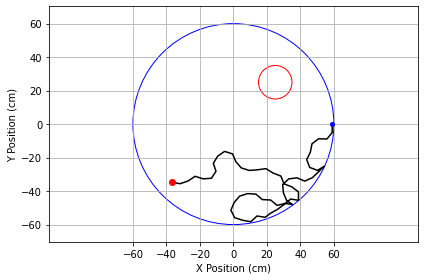

In [297]:
# demo of how to use the watermaze module

# create the watermaze object
maze = watermaze()

# set the starting location
maze.startposition()

# run forward for one trial (using random actions for sake of illustration)
while(not maze.timeup() and not maze.atgoal()):
    
    # select a random action - this is what your actor critic network needs to provide
    A = np.random.randint(0,8)
    # move the rat
    maze.move(A)
    
# plot the path
maze.plotpath()

# print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
if maze.atgoal():
    print("Clever rat, you found the platform in", maze.t, "seconds!")
else:
    print("No more time for you dumb-dumb...")

# TD Models

## Helper Functions: Even Distribution of Points on Circle Using Golden Ratio

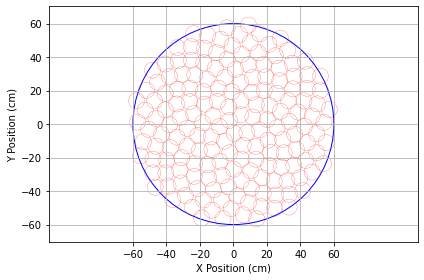

In [209]:
def sunflower(n, circle_radius, alpha=0):
    '''
    Evenly distribute n points in a circle using golden ratio
    Return coordinates of points
    From: stackoverflow.com/questions/28567166/uniformly-distribute-x-points-inside-a-circle
    
    Parameters:
        alpha: higher means more points placed on circle boundary/perimeter
    '''
    n_boundary_ptns = round(alpha * np.sqrt(n)) # number of boundary points
    phi = (np.sqrt(5)+1)/2                      # golden ratio
    ptns = np.zeros((n, 2))

    for i in range(1, n+1):
        r = radius(i, n, n_boundary_ptns, circle_radius);
        theta = 2*np.pi*i/phi**2
        ptns[i-1] = r*np.cos(theta), r*np.sin(theta)
    return ptns

def radius(ptn_idx, n, n_boundary_ptns, circle_radius):
    '''
    Return radius, or distance of point from center
    '''
    r = circle_radius # put on boundary
    if ptn_idx <= n-n_boundary_ptns:
        r *= np.sqrt(ptn_idx-1/2)/np.sqrt(n-(n_boundary_ptns+1)/2) # apply square root
    return r

# Plot pool
fig = plt.figure()
ax = plt.gca()
pool_radius = 60
pool_perimeter = plt.Circle((0, 0), pool_radius, fill=False, color='b', ls='-')
ax.add_artist(pool_perimeter)

# Plot place fields
centers = sunflower(177, pool_radius, alpha=0)
for x,y in centers:
    # plt.plot(x, y, color='r', marker='+', markersize=1, markerfacecolor='r')
    place_field = plt.Circle((x,y), 4.8, fill=False, color='r', ls='-', lw=0.2)
    ax.add_artist(place_field)

# Adjust axes
ax.axis('equal')
ax.set_xlim((-pool_radius-50, pool_radius+50))
ax.set_ylim((-pool_radius-50, pool_radius+50))
plt.xticks(np.arange(-pool_radius, pool_radius+20, step=20))
plt.yticks(np.arange(-pool_radius, pool_radius+20, step=20))
ax.set_xlabel('X Position (cm)')
ax.set_ylabel('Y Position (cm)')

# Turn on grid
plt.grid(True)
plt.tight_layout()
plt.show()

## Environment - Encapsulates Water Maze and Agent (Actor-Critic or Coordinate-Based Actor-Critic)

In [0]:
class Environment:
    '''
    At any given time t, the environment provides the animal with a reward Rt.
    Reward always 0 except when rat reaches platform, then it's 1.
    '''
    def __init__(self, agent):
        self.maze  = watermaze()
        agent.maze = self.maze
        agent.S    = sunflower(agent.n, agent.maze.radius) # Init place fields centers
        self.agent = agent

        self.startposition()
    
    def sim_ep(self):
        '''
        Simulate an episode
        '''
        while not self.maze.timeup() and not self.maze.atgoal():
            # Choose action
            a = self.agent.action()
            # Move the rat and update weights, reward if goal reached
            self.agent.move(a)
    
    def restart(self):
        '''
        Reset maze
        '''
        self.maze.position[:] = 0
        self.maze.prevdir[:]  = 0
        self.maze.t           = 0
        self.startposition()
    
    def startposition(self):
        '''
        Get new start position and restart agent
        '''
        self.maze.startposition()
        self.agent.restart()

    def plot(self, fields=False):
        '''
        Plot path and place fields
        '''
        plt, ax = self.maze.plotpath()

        # Plot place fields
        if fields:
            for x, y in self.agent.S:
                # plt.plot(x, y, color='b', marker='+',markersize=1, markerfacecolor='b')
                place_field = plt.Circle((x,y), self.agent.sigma/2, fill=False, color='g', ls='-', lw=0.2)
                ax.add_artist(place_field)
        plt.show()

## Pure Actor-Critic: Reward-Based Navigation

In [0]:
class ActorCritic:
    def __init__(self, n=250, sigma=5, discount=0.9, etaa=0.01, etac=0.03):        
        self.maze = None
        self.S    = None # Place fields centers

        self.PC = np.zeros(n)      # Place cells
        self.A  = np.zeros(8)      # Action cells
        self.Z  = np.zeros((8, n)) # Action cells weights
        self.C  = 0                # Critic cell
        self.W  = np.zeros(n)      # Critic cells weights

        self.n        = n        # Number of place cells
        self.sigma    = sigma    # Place field breadth
        self.discount = discount # Discount factor
        self.etaa     = etaa     # Actor learning rate
        self.etac     = etac     # Critic learning rate

        self.p = np.zeros(2) # Position
        self.R = 0           # Reward

    def action(self):
        '''
        Pick action, integer in [0,7], according to preferences
        '''
        return np.random.choice(8, 1, p=self.P())[0]

    def move(self, a):
        '''
        Move agent and update weights
        '''
        # Save terms to compute weight updates
        C_prev = self.Cp()
        PC_prev = self.fp()
        self.PC = PC_prev

        # Move agent
        self._move(a)

        # Update weights
        self.update(a, C_prev, PC_prev)
        self.PC = self.fp()
    
    def update(self, a, C_prev, PC_prev):
        '''
        Update weights using predicition error (Equation 7),
        dW (Equation 8), and dZ (Equation 10)
        '''
        if self.R == 0:
            # Reward = 0: not yet reached goal
            d  = self.discount*self.Cp() - C_prev # Equation 7: prediction error
            dW = self.etac * d * PC_prev
            self.Z += self.dZ(a, d, PC_prev) # Update action cells weights
        else:
            # Reward == 1: reached goal
            d  = self.R - self.C # Equation 7: prediction error
            dW = self.etac * d * self.fp()

        self.W += dW # Update critic cells weights

    def fp(self):
        '''
        Equation 1:
        Place cells activity
        '''
        p_dist = np.linalg.norm(self.p - self.S, axis=1) 
        return np.exp(-p_dist/(2*self.sigma**2))
    
    def Cp(self):
        '''
        Equation 2:
        Critic cell firing rate
        '''
        self.C = self.W.dot(self.fp())
        return self.C
    
    def P(self):
        '''
        Equation 9:
        Actual swimming direction is chosen stochastically
        with probabilities P related to action cell activity
        '''
        A = self.Ap()
        P = np.exp(2*A)/np.sum(np.exp(2*A))
        return P
    
    def Ap(self):
        '''
        Action cells activity.
        Relative preference for each action at location p
        '''
        self.A = self.fp().dot(self.Z.T)
        return self.A
    
    def dZ(self, a, d, PC):
        '''
        Equation 10:
        Action cells weights update
        '''
        g = np.zeros((8,1))
        g[a] = 1
        dZ = self.etaa * d * g.dot(PC.reshape(1, self.n))
        return dZ
    
    def _move(self, a):
        '''
        Move agent, update position and save reward
        '''
        new_position = self.maze.move(a)
        self.p       = new_position
        self.R       = int(self.maze.atgoal()) # Save reward
    
    def restart(self):
        '''
        Reset position and reward
        '''
        self.p = self.maze.position[:,0]
        self.R = 0
    
    def reset(self):
        '''
        Restart and reset weights
        '''
        self.restart()
        self.PC[:] = 0
        self.A[:]  = 0
        self.Z[:]  = 0
        self.C     = 0
        self.W[:]  = 0

### Demo

Episode: 0


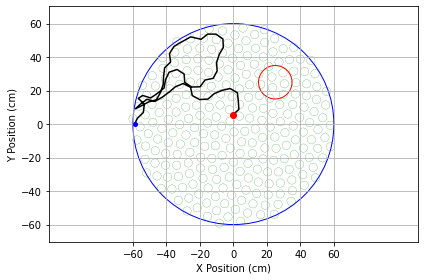

Failure

Episode: 499


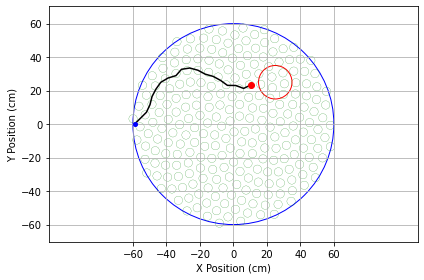

Success, t = 19


Success rate: 0.936


In [304]:
agent = ActorCritic()
env = Environment(agent)

succ = 0
n_eps = 500

for ep in tqdm(range(n_eps)):
    # Simulate an episode
    env.sim_ep()
        
    # Plot first and last path
    if ep == 0 or ep == n_eps-1:
        print('Episode:', ep)
        env.plot(fields=True)
        print(f'Success, t = {env.maze.t}\n' if env.maze.atgoal() else 'Failure\n')

    # print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
    if env.maze.atgoal(): succ += 1

    # Reset water maze and starting position
    env.restart()

print('Success rate:', succ/n_eps)

## Coordinate-Based Actor-Critic

In [0]:
class CoordBased(ActorCritic):
    def __init__(self, lamb=0.9, etaxy=np.array([[0.01],[0.01]]), etaa_coord=0.01, **kwargs):
        super().__init__(**kwargs)

        self.XYgoal = None                  # Remembered goal coordinates
        self.XY     = np.zeros(2)           # Cur position cells activity
        self.Wxy    = np.zeros((2, self.n)) # Cur position cells weights
        self.A      = np.zeros(9)           # Action cells + new abstract action cell
        self.Z      = np.zeros((9, self.n)) # Action cells weights with new row for abstract action cell

        self.etaxy      = etaxy      # Wxy learning rate
        self.etaa_coord = etaa_coord # Abstract action cell learning rate

        self.lamb      = lamb             # Lambda for Wxy update dWxy
        self.S_lamb_fp = np.zeros(self.n) # Summation term for dWxy
    
    def action(self):
        '''
        Pick action, integer in [0,8], according to preferences
        '''
        P = self.P()
        a = np.random.choice(9, 1, p=P)[0]

        # Choose a normal action if no remembered goal coordinates
        if a == 8 and self.XYgoal is None:
            P = P[:-1] + P[-1]/8
            a = np.random.choice(8, 1, p=P)[0]

        return a
    
    def move(self, a):
        '''
        Move agent and update weights
        '''
        # Save terms to compute weight updates
        C_prev   = self.Cp()
        PC_prev  = self.fp()
        XYp_prev = self.XYp()
        p_prev   = self.p # Save current position
        self.PC  = PC_prev
        
        # Update summation term for dWxy
        self.S_lamb_fp = self.lamb * self.S_lamb_fp + PC_prev

        # If abstract action chosen, compute angle
        angle = None
        if a == 8:
            diff  = self.XYgoal - self.p
            angle = np.arctan2(diff[1], diff[0])

        # Move agent
        self._move(a, angle)

        # Update weights
        self.update(a, C_prev, PC_prev, XYp_prev, p_prev)
    
    def update(self, a, C_prev, PC_prev, XYp_prev, p_prev):
        '''
        Update weights
        '''
        super().update(a, C_prev, PC_prev)

        # Update Wxy
        dWxy = self.dWxy(XYp_prev, p_prev)
        self.Wxy += dWxy

        if self.R == 0:
            # Hasn't reached goal
            # Forget previous goal coordintes if reached location thought to be goal
            if self.XYgoal is not None and self.is_at_prev_goal():
                self.XYgoal = None
        else:
            # Reached goal, remember goal location
            self.XYgoal = self.maze.platform_location
    
    def dZ(self, a, d, PC):
        '''
        Equation 10:
        Action cells weights update
        '''
        g    = np.zeros((9,1))
        g[a] = 1

        # Choose etaa_coord as learning rate if chose abstract action, else use etaa
        eta = self.etaa_coord if a == 8 else self.etaa
        return eta * d * g.dot(PC.reshape(1, self.n))

    def XYp(self):
        '''
        Cur position cells activity
        '''
        self.XY = self.Wxy.dot(self.fp())
        return self.XY
    
    def dWxy(self, XYp_prev, p_prev):
        '''
        Equations 11 and 12:
        Wxy weights update
        '''
        dxy       = (self.p - p_prev).reshape(2,1)
        diff      = (self.XYp() - XYp_prev).reshape(2,1)
        S_lamb_fp = self.S_lamb_fp.reshape(1,self.n)
        return self.etaxy*(dxy - diff.dot(S_lamb_fp))
    
    def _move(self, a, angle):
        '''
        Move agent, update position and save reward
        '''
        new_position = self.maze.move(a, angle)
        self.p       = new_position
        self.R       = int(self.maze.atgoal()) # Save reward
    
    def is_at_prev_goal(self):
        '''
        Check if reached remembered goal coordinates
        '''
        return np.sqrt(np.sum((self.p - self.XYgoal)**2)) <= (self.maze.platform_radius + 1)

### Demo

Episode: 0


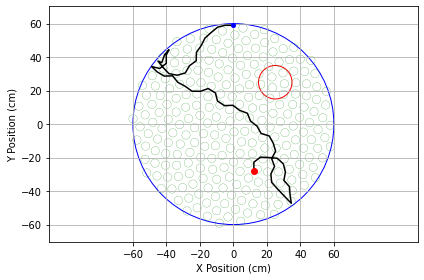

Failure

Episode: 99


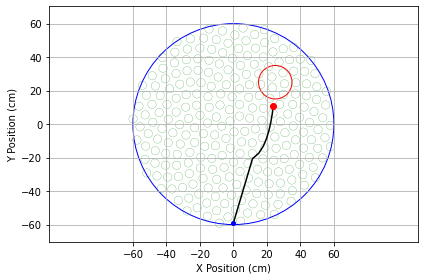

Success, t = 16


Success rate: 0.95


In [215]:
agent = CoordBased()
env = Environment(agent)

n_eps = 100
succ = 0

for ep in tqdm(range(n_eps)):
    # Simulate an episode
    env.sim_ep()
        
    # Plot first and last path
    if ep == 0 or ep == n_eps-1:
        print('Episode:', ep)
        env.plot(fields=True)
        print(f'Success, t = {env.maze.t}\n' if env.maze.atgoal() else 'Failure\n')

    if env.maze.atgoal(): succ += 1

    # Reset water maze and starting position
    env.restart()

print('Success rate:', succ/n_eps)

# Plots: Path Lengths Measured Across Simulations

## Helper Function: Plot Path Lengths Across Simultions

In [0]:
def test(agent,
         n_eps          = 100,   # Episodes to simulate for single-platform case
         multiplatform  = False, # Multplatform flag
         platform_sched = None,  # Platform schedule as {day: platform location} dict
         days           = None,  # Multiplatform: number of days
         ptns_per_day   = None,  # Multiplatform: number of points per day
         eps_per_ptn    = None,  # Multiplatform: number of episodes per point
         plot           = True): # Plot flag
    '''
    Single-platform case (RMW task):
        Simulate `n_eps` episodes, plot first and last paths,
        print success rate over all episodes
    
    Multiplatform case (DMP task):
        Simulate across `days` days according multiplatform parameters.
        Plot mean and standard error path lengths across simulations

        Note:
        `platform_sched` can include only one platform location
        to simulate single-platform case/RMW task
    '''
    env = Environment(agent)
    agent.reset()

    # Single-platform case
    if not multiplatform:
        singleplatform(env, n_eps, plot)
        return

    # Multiplatform case
    succ = 0

    means = np.zeros(ptns_per_day*days) # Path length means
    stds  = np.zeros(ptns_per_day*days) # Path length standard deviations
    
    path_lens = np.zeros(eps_per_ptn) # Store path lengths for a data point
    
    for day in tqdm(range(days)):
        # Move platform according to schedule
        if day in platform_sched:
            env.maze.platform_location = platform_sched[day]

        # Collect mean and std deviation for each point
        for ptn in range(ptns_per_day):
            for ep in range(eps_per_ptn):
                env.sim_ep()

                path          = env.maze.position[:,:env.maze.t+1].T
                path_len      = sum(np.linalg.norm(path[i+1]-path[i]) for i in range(path.shape[0]-1))
                path_lens[ep] = path_len

                # Success
                if env.maze.atgoal(): succ += 1
                env.restart()

            means[ptns_per_day*day+ptn] = np.mean(path_lens)
            stds[ptns_per_day*day+ptn]  = np.std(path_lens)
            path_lens[:] = 0

    stderrs = stds/np.sqrt(eps_per_ptn) # Path length standard errors

    if plot:
        fig = plt.figure(figsize=(10,8))
        ax  = fig.gca()
        ax.set_xlabel('DAY', fontsize = 18)
        ax.set_ylabel('PATH LENGTH (cm)', fontsize = 18)
        ax.set_ylim((0, 300))

        plt.xticks([i for i in range(1, days+1)])

        xaxis = np.array([1+d+p/ptns_per_day for d in range(days) for p in range(ptns_per_day)])
        # plt.errorbar(xaxis, means, stderrs, fmt='_-k', linewidth=1, capsize=3)
        for day in range(days):
            start = day * ptns_per_day
            end   = start + ptns_per_day 

            plt.errorbar(xaxis[start:end], means[start:end], stderrs[start:end], fmt='_-k', linewidth=1, capsize=3)
        
        fig = plt.gcf()
        plt.show()
    
    print('Success rate:', succ/(days*ptns_per_day*eps_per_ptn))
    if plot: return fig


def singleplatform(env, n_eps=100, plot=True):
    '''
    Single-platform case
    '''
    succ = 0

    for ep in tqdm(range(n_eps)):
        env.sim_ep() # Simulate an episode
            
        # plot the path
        if plot and (ep == 0 or ep == n_eps-1):
            print('Episode:', ep)
            env.plot(fields=True)
            print(f'Success, t = {env.maze.t}\n' if env.maze.atgoal() else 'Failure\n')

        if env.maze.atgoal(): succ += 1            
        env.restart()

    print('Success rate:', succ/n_eps)

## Actor-Critic Performance

### RMW Task

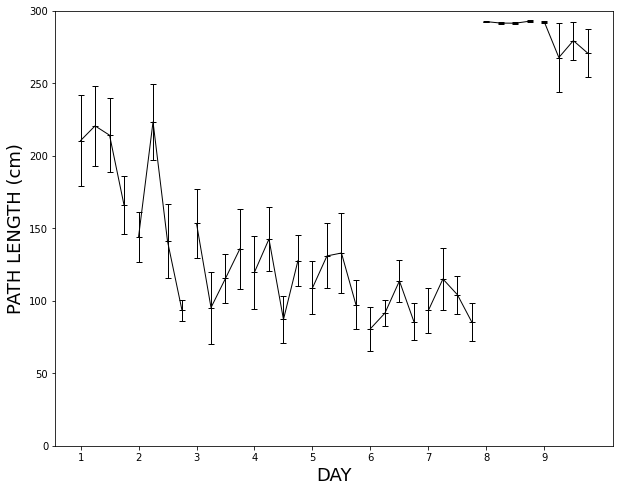

Success rate: 0.7111111111111111


In [281]:
# Same platform location for 7 days, then moved to opposite quadrant
rmw_params = {
    'platform_sched': {
        0: np.array([25, 25]),
        7: np.array([-25, -25])
    },
    'days': 9,
    'ptns_per_day': 4,
    'eps_per_ptn': 10,
}
agent = ActorCritic()
fig = test(agent, multiplatform=True, **rmw_params)
fig.savefig('ac_rmw.png')

### DMP Task

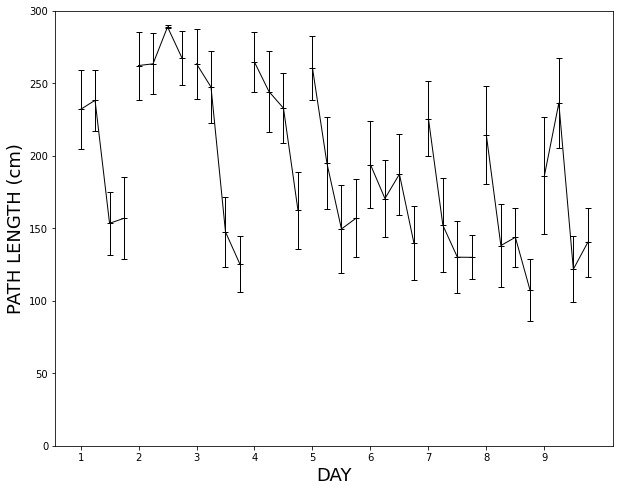

Success rate: 0.5888888888888889


In [284]:
# New platform location every day
dmp_params = {
    'platform_sched': {
        0: np.array([25, 25]),
        1: np.array([-25, -25]),
        2: np.array([-25, 25]),
        3: np.array([25, -25]),
        7: np.array([-25, 0]),
        8: np.array([25, 0]),
        6: np.array([0, 25]),
        5: np.array([0, -25]),
        4: np.array([0, 0]),
    },
    'days': 9,
    'ptns_per_day': 4,
    'eps_per_ptn': 10,
}
agent = ActorCritic()
fig = test(agent, multiplatform=True, **dmp_params)
fig.savefig('ac_dmp.png')

## Coordinate-Based Actor-Critic Performance

### RMW Task

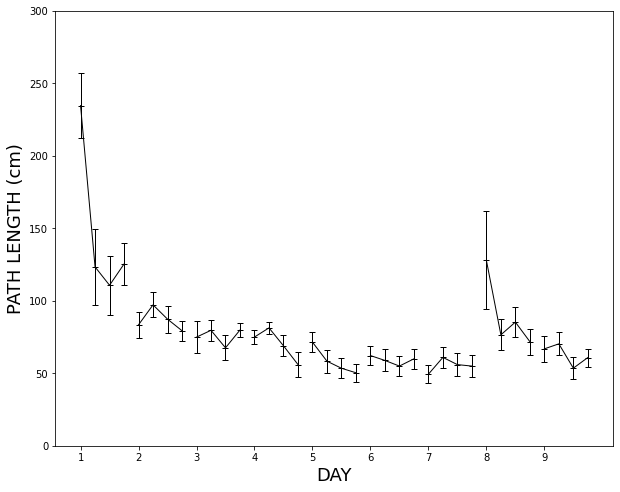

Success rate: 0.9722222222222222


In [286]:
agent = CoordBased()
fig = test(agent, multiplatform=True, **rmw_params)
fig.savefig('cac_rmw.png')

### DMP Task

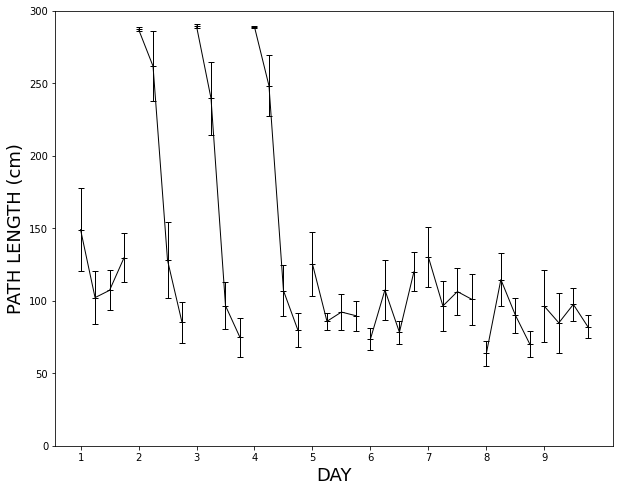

Success rate: 0.8416666666666667


In [291]:
agent = CoordBased()
fig = test(agent, multiplatform=True, **dmp_params)
fig.savefig('cac_dmp.png')